In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Mar 10 09:00:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   32C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import All_CNN8Layer_W as ModelW
from model.models_mjp_26December20 import All_CNN10Layer_X as ModelX
from model.models_mjp_26December20 import All_CNN8Layer_Y as ModelY
from model.models_mjp_30Jan21_AllCNN import ACN_2_10L_4S_BN as ModelXX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 500, 1e-6, 820)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## This is used when training with the original KDE
'''
## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)
'''

## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 15.89 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 16.48 s
Constructing 160000 event dataset took 9.432 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 3.767 s
Constructing 20000 event dataset took 0.1876 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelXX()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/983605f0a0924f3dadb8f3b260d4f5e4/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 32.5 parameter layers to update in the current model, 32.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ACN_2_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dr

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


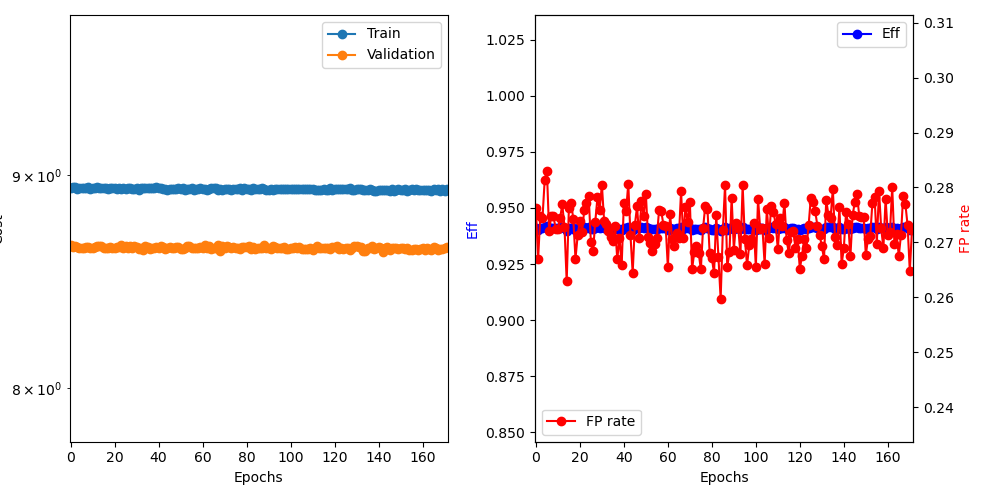

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'ACN_2_10L_4S_BN Cont. (P4)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE', 'Poca')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  ACN_2_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 820: train=8.93579, val=8.65985, took 52.458 s
  Validation Found 101645 of 108007, added 5525 (eff 94.11%) (0.276 FP/event)
Result epoch:  820
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 821: train=8.94161, val=8.65143, took 52.442 s
  Validation Found 101563 of 108007, added 5339 (eff 94.03%) (0.267 FP/event)
Result epoch:  821
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 822: train=8.93988, val=8.6519, took 51.497 s
  Validation Found 101650 of 108007, added 5496 (eff 94.11%) (0.275 FP/event)
Result epoch:  822
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 823: train=8.93202, val=8.6473, took 51.032 s
  Validation Found 101663 of 108007, added 5490 (eff 94.13%) (0.274 FP/event)
Result epoch:  823
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 824: train=8.937, val=8.64471, took 51.072 s
  Validation Found 101707 of 108007, added 5628 (eff 94.17%) (0.281 FP/event)
Result epoch:  824
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 825: train=8.93527, val=8.64489, took 51.086 s
  Validation Found 101733 of 108007, added 5662 (eff 94.19%) (0.283 FP/event)
Result epoch:  825
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 826: train=8.93599, val=8.64357, took 50.972 s
  Validation Found 101614 of 108007, added 5442 (eff 94.08%) (0.272 FP/event)
Result epoch:  826
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 827: train=8.93429, val=8.65149, took 50.843 s
  Validation Found 101650 of 108007, added 5497 (eff 94.11%) (0.275 FP/event)
Result epoch:  827
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 828: train=8.93932, val=8.64717, took 50.927 s
  Validation Found 101653 of 108007, added 5495 (eff 94.12%) (0.275 FP/event)
Result epoch:  828
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 829: train=8.93374, val=8.64614, took 50.932 s
  Validation Found 101634 of 108007, added 5450 (eff 94.10%) (0.272 FP/event)
Result epoch:  829
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 830: train=8.93586, val=8.64587, took 51.081 s
  Validation Found 101628 of 108007, added 5449 (eff 94.09%) (0.272 FP/event)
Result epoch:  830
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 831: train=8.93873, val=8.64862, took 51.857 s
  Validation Found 101647 of 108007, added 5488 (eff 94.11%) (0.274 FP/event)
Result epoch:  831
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 832: train=8.9402, val=8.65254, took 52.358 s
  Validation Found 101669 of 108007, added 5539 (eff 94.13%) (0.277 FP/event)
Result epoch:  832
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 833: train=8.93472, val=8.6557, took 52.36 s
  Validation Found 101618 of 108007, added 5456 (eff 94.08%) (0.273 FP/event)
Result epoch:  833
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 834: train=8.9387, val=8.65366, took 52.293 s
  Validation Found 101504 of 108007, added 5258 (eff 93.98%) (0.263 FP/event)
Result epoch:  834
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 835: train=8.93885, val=8.64627, took 52.268 s
  Validation Found 101660 of 108007, added 5524 (eff 94.12%) (0.276 FP/event)
Result epoch:  835
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 836: train=8.93757, val=8.64523, took 52.138 s
  Validation Found 101664 of 108007, added 5544 (eff 94.13%) (0.277 FP/event)
Result epoch:  836
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 837: train=8.93355, val=8.64208, took 51.048 s
  Validation Found 101636 of 108007, added 5486 (eff 94.10%) (0.274 FP/event)
Result epoch:  837
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 838: train=8.93701, val=8.64909, took 51.93 s
  Validation Found 101561 of 108007, added 5341 (eff 94.03%) (0.267 FP/event)
Result epoch:  838
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 839: train=8.93697, val=8.64592, took 52.28 s
  Validation Found 101621 of 108007, added 5427 (eff 94.09%) (0.271 FP/event)
Result epoch:  839
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 840: train=8.93646, val=8.64567, took 52.358 s
  Validation Found 101638 of 108007, added 5480 (eff 94.10%) (0.274 FP/event)
Result epoch:  840
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 841: train=8.93406, val=8.64707, took 52.246 s
  Validation Found 101619 of 108007, added 5439 (eff 94.09%) (0.272 FP/event)
Result epoch:  841
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 842: train=8.93659, val=8.64677, took 52.336 s
  Validation Found 101677 of 108007, added 5519 (eff 94.14%) (0.276 FP/event)
Result epoch:  842
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 843: train=8.93116, val=8.65771, took 52.323 s
  Validation Found 101664 of 108007, added 5545 (eff 94.13%) (0.277 FP/event)
Result epoch:  843
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 844: train=8.93596, val=8.64283, took 52.363 s
  Validation Found 101681 of 108007, added 5569 (eff 94.14%) (0.278 FP/event)
Result epoch:  844
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 845: train=8.93254, val=8.65268, took 51.364 s
  Validation Found 101592 of 108007, added 5402 (eff 94.06%) (0.27 FP/event)
Result epoch:  845
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 846: train=8.93857, val=8.64531, took 51.078 s
  Validation Found 101574 of 108007, added 5370 (eff 94.04%) (0.268 FP/event)
Result epoch:  846
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 847: train=8.93774, val=8.65304, took 50.967 s
  Validation Found 101634 of 108007, added 5476 (eff 94.10%) (0.274 FP/event)
Result epoch:  847
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 848: train=8.93348, val=8.64274, took 50.947 s
  Validation Found 101675 of 108007, added 5565 (eff 94.14%) (0.278 FP/event)
Result epoch:  848
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 849: train=8.933, val=8.65575, took 50.446 s
  Validation Found 101650 of 108007, added 5518 (eff 94.11%) (0.276 FP/event)
Result epoch:  849
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 850: train=8.93481, val=8.64793, took 50.459 s
  Validation Found 101694 of 108007, added 5611 (eff 94.16%) (0.281 FP/event)
Result epoch:  850
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 851: train=8.92891, val=8.64074, took 50.431 s
  Validation Found 101636 of 108007, added 5480 (eff 94.10%) (0.274 FP/event)
Result epoch:  851
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 852: train=8.93768, val=8.64482, took 50.427 s
  Validation Found 101625 of 108007, added 5468 (eff 94.09%) (0.273 FP/event)
Result epoch:  852
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 853: train=8.93579, val=8.63604, took 50.588 s
  Validation Found 101625 of 108007, added 5442 (eff 94.09%) (0.272 FP/event)
Result epoch:  853
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 854: train=8.93852, val=8.65288, took 50.65 s
  Validation Found 101606 of 108007, added 5420 (eff 94.07%) (0.271 FP/event)
Result epoch:  854
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 855: train=8.9389, val=8.6487, took 50.479 s
  Validation Found 101606 of 108007, added 5405 (eff 94.07%) (0.27 FP/event)
Result epoch:  855
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 856: train=8.93726, val=8.64049, took 50.455 s
  Validation Found 101634 of 108007, added 5460 (eff 94.10%) (0.273 FP/event)
Result epoch:  856
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 857: train=8.9371, val=8.64335, took 50.499 s
  Validation Found 101577 of 108007, added 5339 (eff 94.05%) (0.267 FP/event)
Result epoch:  857
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 858: train=8.93664, val=8.64441, took 50.5 s
  Validation Found 101607 of 108007, added 5418 (eff 94.07%) (0.271 FP/event)
Result epoch:  858
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 859: train=8.94048, val=8.6477, took 50.441 s
  Validation Found 101542 of 108007, added 5318 (eff 94.01%) (0.266 FP/event)
Result epoch:  859
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 860: train=8.93429, val=8.64408, took 50.651 s
  Validation Found 101663 of 108007, added 5544 (eff 94.13%) (0.277 FP/event)
Result epoch:  860
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 861: train=8.93488, val=8.65296, took 50.427 s
  Validation Found 101648 of 108007, added 5514 (eff 94.11%) (0.276 FP/event)
Result epoch:  861
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 862: train=8.93005, val=8.65044, took 50.424 s
  Validation Found 101699 of 108007, added 5614 (eff 94.16%) (0.281 FP/event)
Result epoch:  862
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 863: train=8.93132, val=8.64083, took 50.471 s
  Validation Found 101623 of 108007, added 5427 (eff 94.09%) (0.271 FP/event)
Result epoch:  863
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 864: train=8.92871, val=8.64394, took 50.378 s
  Validation Found 101532 of 108007, added 5288 (eff 94.01%) (0.264 FP/event)
Result epoch:  864
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 865: train=8.93045, val=8.6483, took 50.363 s
  Validation Found 101638 of 108007, added 5465 (eff 94.10%) (0.273 FP/event)
Result epoch:  865
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 866: train=8.93357, val=8.64534, took 50.219 s
  Validation Found 101654 of 108007, added 5531 (eff 94.12%) (0.277 FP/event)
Result epoch:  866
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 867: train=8.93127, val=8.64665, took 50.403 s
  Validation Found 101623 of 108007, added 5416 (eff 94.09%) (0.271 FP/event)
Result epoch:  867
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 868: train=8.93302, val=8.64879, took 50.425 s
  Validation Found 101679 of 108007, added 5552 (eff 94.14%) (0.278 FP/event)
Result epoch:  868
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 869: train=8.93441, val=8.64837, took 50.682 s
  Validation Found 101638 of 108007, added 5498 (eff 94.10%) (0.275 FP/event)
Result epoch:  869
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 870: train=8.93178, val=8.6411, took 50.422 s
  Validation Found 101696 of 108007, added 5577 (eff 94.16%) (0.279 FP/event)
Result epoch:  870
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 871: train=8.9361, val=8.64124, took 50.412 s
  Validation Found 101621 of 108007, added 5419 (eff 94.09%) (0.271 FP/event)
Result epoch:  871
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 872: train=8.92598, val=8.64531, took 50.419 s
  Validation Found 101607 of 108007, added 5399 (eff 94.07%) (0.27 FP/event)
Result epoch:  872
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 873: train=8.93397, val=8.65322, took 50.432 s
  Validation Found 101584 of 108007, added 5368 (eff 94.05%) (0.268 FP/event)
Result epoch:  873
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 874: train=8.93216, val=8.65207, took 50.429 s
  Validation Found 101587 of 108007, added 5394 (eff 94.06%) (0.27 FP/event)
Result epoch:  874
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 875: train=8.93758, val=8.64559, took 50.416 s
  Validation Found 101615 of 108007, added 5417 (eff 94.08%) (0.271 FP/event)
Result epoch:  875
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 876: train=8.92816, val=8.64628, took 50.461 s
  Validation Found 101646 of 108007, added 5519 (eff 94.11%) (0.276 FP/event)
Result epoch:  876
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 877: train=8.93226, val=8.6422, took 50.41 s
  Validation Found 101646 of 108007, added 5515 (eff 94.11%) (0.276 FP/event)
Result epoch:  877
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 878: train=8.93238, val=8.64535, took 50.517 s
  Validation Found 101637 of 108007, added 5462 (eff 94.10%) (0.273 FP/event)
Result epoch:  878
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 879: train=8.93706, val=8.64785, took 50.393 s
  Validation Found 101629 of 108007, added 5461 (eff 94.09%) (0.273 FP/event)
Result epoch:  879
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 880: train=8.93292, val=8.64311, took 50.67 s
  Validation Found 101565 of 108007, added 5309 (eff 94.04%) (0.265 FP/event)
Result epoch:  880
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 881: train=8.92985, val=8.6565, took 50.484 s
  Validation Found 101655 of 108007, added 5503 (eff 94.12%) (0.275 FP/event)
Result epoch:  881
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 882: train=8.92868, val=8.64294, took 50.414 s
  Validation Found 101602 of 108007, added 5411 (eff 94.07%) (0.271 FP/event)
Result epoch:  882
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 883: train=8.93049, val=8.65383, took 50.423 s
  Validation Found 101580 of 108007, added 5387 (eff 94.05%) (0.269 FP/event)
Result epoch:  883
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 884: train=8.93876, val=8.64064, took 50.394 s
  Validation Found 101620 of 108007, added 5435 (eff 94.09%) (0.272 FP/event)
Result epoch:  884
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 885: train=8.93532, val=8.64618, took 50.422 s
  Validation Found 101604 of 108007, added 5417 (eff 94.07%) (0.271 FP/event)
Result epoch:  885
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 886: train=8.93479, val=8.64628, took 50.428 s
  Validation Found 101696 of 108007, added 5587 (eff 94.16%) (0.279 FP/event)
Result epoch:  886
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 887: train=8.92738, val=8.66041, took 50.519 s
  Validation Found 101615 of 108007, added 5416 (eff 94.08%) (0.271 FP/event)
Result epoch:  887
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 888: train=8.93172, val=8.63233, took 50.56 s
  Validation Found 101667 of 108007, added 5530 (eff 94.13%) (0.276 FP/event)
Result epoch:  888
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 889: train=8.92738, val=8.65225, took 50.499 s
  Validation Found 101628 of 108007, added 5473 (eff 94.09%) (0.274 FP/event)
Result epoch:  889
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 890: train=8.93212, val=8.64638, took 50.498 s
  Validation Found 101656 of 108007, added 5549 (eff 94.12%) (0.277 FP/event)
Result epoch:  890
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 891: train=8.9326, val=8.65514, took 50.518 s
  Validation Found 101543 of 108007, added 5302 (eff 94.02%) (0.265 FP/event)
Result epoch:  891
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 892: train=8.93173, val=8.65012, took 50.548 s
  Validation Found 101571 of 108007, added 5364 (eff 94.04%) (0.268 FP/event)
Result epoch:  892
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 893: train=8.92827, val=8.64454, took 50.502 s
  Validation Found 101576 of 108007, added 5387 (eff 94.05%) (0.269 FP/event)
Result epoch:  893
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 894: train=8.93361, val=8.65128, took 50.546 s
  Validation Found 101573 of 108007, added 5362 (eff 94.04%) (0.268 FP/event)
Result epoch:  894
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 895: train=8.93198, val=8.64432, took 50.545 s
  Validation Found 101539 of 108007, added 5302 (eff 94.01%) (0.265 FP/event)
Result epoch:  895
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 896: train=8.932, val=8.64388, took 50.544 s
  Validation Found 101638 of 108007, added 5451 (eff 94.10%) (0.273 FP/event)
Result epoch:  896
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 897: train=8.93654, val=8.63803, took 50.498 s
  Validation Found 101688 of 108007, added 5533 (eff 94.15%) (0.277 FP/event)
Result epoch:  897
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 898: train=8.92831, val=8.65095, took 50.5 s
  Validation Found 101628 of 108007, added 5522 (eff 94.09%) (0.276 FP/event)
Result epoch:  898
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 899: train=8.93471, val=8.65117, took 50.497 s
  Validation Found 101575 of 108007, added 5361 (eff 94.04%) (0.268 FP/event)
Result epoch:  899
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 900: train=8.93399, val=8.65051, took 50.993 s
  Validation Found 101556 of 108007, added 5343 (eff 94.03%) (0.267 FP/event)
Result epoch:  900
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 901: train=8.93233, val=8.65342, took 51.857 s
  Validation Found 101532 of 108007, added 5288 (eff 94.01%) (0.264 FP/event)
Result epoch:  901
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 902: train=8.92592, val=8.6392, took 51.957 s
  Validation Found 101637 of 108007, added 5499 (eff 94.10%) (0.275 FP/event)
Result epoch:  902
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 903: train=8.9345, val=8.64818, took 51.838 s
  Validation Found 101572 of 108007, added 5347 (eff 94.04%) (0.267 FP/event)
Result epoch:  903
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 904: train=8.93137, val=8.63956, took 50.67 s
  Validation Found 101492 of 108007, added 5194 (eff 93.97%) (0.26 FP/event)
Result epoch:  904
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 905: train=8.92971, val=8.6434, took 50.427 s
  Validation Found 101617 of 108007, added 5444 (eff 94.08%) (0.272 FP/event)
Result epoch:  905
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 906: train=8.93134, val=8.64587, took 50.396 s
  Validation Found 101686 of 108007, added 5609 (eff 94.15%) (0.28 FP/event)
Result epoch:  906
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 907: train=8.93418, val=8.64621, took 50.451 s
  Validation Found 101557 of 108007, added 5312 (eff 94.03%) (0.266 FP/event)
Result epoch:  907
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 908: train=8.93059, val=8.65855, took 50.45 s
  Validation Found 101574 of 108007, added 5364 (eff 94.04%) (0.268 FP/event)
Result epoch:  908
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 909: train=8.92865, val=8.64264, took 50.439 s
  Validation Found 101681 of 108007, added 5563 (eff 94.14%) (0.278 FP/event)
Result epoch:  909
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 910: train=8.92745, val=8.64489, took 50.39 s
  Validation Found 101586 of 108007, added 5374 (eff 94.06%) (0.269 FP/event)
Result epoch:  910
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 911: train=8.9325, val=8.63995, took 50.692 s
  Validation Found 101656 of 108007, added 5471 (eff 94.12%) (0.274 FP/event)
Result epoch:  911
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 912: train=8.92735, val=8.65415, took 50.512 s
  Validation Found 101638 of 108007, added 5454 (eff 94.10%) (0.273 FP/event)
Result epoch:  912
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 913: train=8.93088, val=8.65113, took 50.501 s
  Validation Found 101583 of 108007, added 5357 (eff 94.05%) (0.268 FP/event)
Result epoch:  913
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 914: train=8.93199, val=8.64453, took 50.537 s
  Validation Found 101695 of 108007, added 5609 (eff 94.16%) (0.28 FP/event)
Result epoch:  914
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 915: train=8.92971, val=8.64211, took 50.859 s
  Validation Found 101616 of 108007, added 5414 (eff 94.08%) (0.271 FP/event)
Result epoch:  915
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 916: train=8.92943, val=8.6425, took 50.885 s
  Validation Found 101574 of 108007, added 5317 (eff 94.04%) (0.266 FP/event)
Result epoch:  916
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 917: train=8.9318, val=8.64874, took 50.89 s
  Validation Found 101600 of 108007, added 5390 (eff 94.07%) (0.269 FP/event)
Result epoch:  917
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 918: train=8.93256, val=8.63835, took 50.904 s
  Validation Found 101610 of 108007, added 5412 (eff 94.08%) (0.271 FP/event)
Result epoch:  918
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 919: train=8.93337, val=8.63956, took 50.638 s
  Validation Found 101633 of 108007, added 5472 (eff 94.10%) (0.274 FP/event)
Result epoch:  919
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 920: train=8.93168, val=8.64578, took 50.556 s
  Validation Found 101562 of 108007, added 5310 (eff 94.03%) (0.265 FP/event)
Result epoch:  920
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 921: train=8.93287, val=8.64357, took 50.472 s
  Validation Found 101678 of 108007, added 5559 (eff 94.14%) (0.278 FP/event)
Result epoch:  921
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 922: train=8.93059, val=8.65034, took 51.385 s
  Validation Found 101605 of 108007, added 5448 (eff 94.07%) (0.272 FP/event)
Result epoch:  922
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 923: train=8.93231, val=8.64254, took 51.891 s
  Validation Found 101620 of 108007, added 5454 (eff 94.09%) (0.273 FP/event)
Result epoch:  923
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 924: train=8.93113, val=8.65137, took 51.899 s
  Validation Found 101569 of 108007, added 5320 (eff 94.04%) (0.266 FP/event)
Result epoch:  924
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 925: train=8.93224, val=8.63932, took 50.801 s
  Validation Found 101658 of 108007, added 5523 (eff 94.12%) (0.276 FP/event)
Result epoch:  925
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 926: train=8.9307, val=8.63974, took 50.613 s
  Validation Found 101619 of 108007, added 5416 (eff 94.09%) (0.271 FP/event)
Result epoch:  926
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 927: train=8.93052, val=8.64142, took 50.556 s
  Validation Found 101672 of 108007, added 5534 (eff 94.13%) (0.277 FP/event)
Result epoch:  927
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 928: train=8.9338, val=8.6411, took 50.537 s
  Validation Found 101645 of 108007, added 5510 (eff 94.11%) (0.275 FP/event)
Result epoch:  928
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 929: train=8.92995, val=8.64561, took 50.812 s
  Validation Found 101631 of 108007, added 5468 (eff 94.10%) (0.273 FP/event)
Result epoch:  929
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 930: train=8.93396, val=8.63615, took 50.495 s
  Validation Found 101614 of 108007, added 5375 (eff 94.08%) (0.269 FP/event)
Result epoch:  930
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 931: train=8.92784, val=8.64566, took 50.642 s
  Validation Found 101648 of 108007, added 5490 (eff 94.11%) (0.274 FP/event)
Result epoch:  931
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 932: train=8.92626, val=8.65305, took 50.819 s
  Validation Found 101639 of 108007, added 5461 (eff 94.10%) (0.273 FP/event)
Result epoch:  932
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 933: train=8.9253, val=8.64413, took 50.831 s
  Validation Found 101675 of 108007, added 5545 (eff 94.14%) (0.277 FP/event)
Result epoch:  933
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 934: train=8.92869, val=8.64585, took 50.53 s
  Validation Found 101612 of 108007, added 5408 (eff 94.08%) (0.27 FP/event)
Result epoch:  934
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 935: train=8.93199, val=8.64341, took 50.461 s
  Validation Found 101591 of 108007, added 5361 (eff 94.06%) (0.268 FP/event)
Result epoch:  935
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 936: train=8.92871, val=8.64564, took 50.497 s
  Validation Found 101624 of 108007, added 5439 (eff 94.09%) (0.272 FP/event)
Result epoch:  936
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 937: train=8.92853, val=8.64352, took 50.542 s
  Validation Found 101630 of 108007, added 5443 (eff 94.10%) (0.272 FP/event)
Result epoch:  937
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 938: train=8.93548, val=8.63989, took 50.548 s
  Validation Found 101592 of 108007, added 5380 (eff 94.06%) (0.269 FP/event)
Result epoch:  938
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 939: train=8.92695, val=8.64813, took 50.528 s
  Validation Found 101603 of 108007, added 5412 (eff 94.07%) (0.271 FP/event)
Result epoch:  939
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 940: train=8.93005, val=8.6478, took 50.609 s
  Validation Found 101554 of 108007, added 5304 (eff 94.03%) (0.265 FP/event)
Result epoch:  940
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 941: train=8.93217, val=8.65519, took 50.554 s
  Validation Found 101576 of 108007, added 5352 (eff 94.05%) (0.268 FP/event)
Result epoch:  941
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 942: train=8.93171, val=8.63739, took 50.735 s
  Validation Found 101633 of 108007, added 5413 (eff 94.10%) (0.271 FP/event)
Result epoch:  942
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 943: train=8.93242, val=8.64298, took 50.779 s
  Validation Found 101590 of 108007, added 5381 (eff 94.06%) (0.269 FP/event)
Result epoch:  943
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 944: train=8.92967, val=8.63799, took 50.433 s
  Validation Found 101623 of 108007, added 5463 (eff 94.09%) (0.273 FP/event)
Result epoch:  944
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 945: train=8.92932, val=8.64645, took 50.464 s
  Validation Found 101674 of 108007, added 5562 (eff 94.14%) (0.278 FP/event)
Result epoch:  945
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 946: train=8.93142, val=8.64202, took 50.442 s
  Validation Found 101668 of 108007, added 5546 (eff 94.13%) (0.277 FP/event)
Result epoch:  946
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 947: train=8.93473, val=8.63671, took 50.426 s
  Validation Found 101668 of 108007, added 5514 (eff 94.13%) (0.276 FP/event)
Result epoch:  947
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 948: train=8.92898, val=8.64232, took 50.467 s
  Validation Found 101646 of 108007, added 5460 (eff 94.11%) (0.273 FP/event)
Result epoch:  948
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 949: train=8.92585, val=8.65293, took 50.465 s
  Validation Found 101611 of 108007, added 5426 (eff 94.08%) (0.271 FP/event)
Result epoch:  949
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 950: train=8.92994, val=8.6516, took 50.44 s
  Validation Found 101591 of 108007, added 5388 (eff 94.06%) (0.269 FP/event)
Result epoch:  950
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 951: train=8.93078, val=8.64945, took 50.427 s
  Validation Found 101570 of 108007, added 5339 (eff 94.04%) (0.267 FP/event)
Result epoch:  951
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 952: train=8.93169, val=8.64969, took 50.47 s
  Validation Found 101674 of 108007, added 5556 (eff 94.14%) (0.278 FP/event)
Result epoch:  952
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 953: train=8.92584, val=8.63101, took 50.413 s
  Validation Found 101682 of 108007, added 5500 (eff 94.14%) (0.275 FP/event)
Result epoch:  953
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 954: train=8.9257, val=8.63159, took 50.387 s
  Validation Found 101670 of 108007, added 5490 (eff 94.13%) (0.274 FP/event)
Result epoch:  954
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 955: train=8.92723, val=8.64417, took 50.405 s
  Validation Found 101702 of 108007, added 5596 (eff 94.16%) (0.28 FP/event)
Result epoch:  955
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 956: train=8.93188, val=8.64486, took 50.4 s
  Validation Found 101613 of 108007, added 5421 (eff 94.08%) (0.271 FP/event)
Result epoch:  956
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 957: train=8.92767, val=8.65395, took 50.423 s
  Validation Found 101590 of 108007, added 5392 (eff 94.06%) (0.27 FP/event)
Result epoch:  957
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 958: train=8.92376, val=8.63892, took 50.423 s
  Validation Found 101681 of 108007, added 5529 (eff 94.14%) (0.276 FP/event)
Result epoch:  958
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 959: train=8.9227, val=8.6461, took 50.396 s
  Validation Found 101571 of 108007, added 5321 (eff 94.04%) (0.266 FP/event)
Result epoch:  959
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 960: train=8.92581, val=8.64773, took 50.494 s
  Validation Found 101589 of 108007, added 5379 (eff 94.06%) (0.269 FP/event)
Result epoch:  960
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 961: train=8.92887, val=8.64321, took 50.474 s
  Validation Found 101646 of 108007, added 5510 (eff 94.11%) (0.275 FP/event)
Result epoch:  961
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 962: train=8.92829, val=8.62716, took 50.408 s
  Validation Found 101663 of 108007, added 5468 (eff 94.13%) (0.273 FP/event)
Result epoch:  962
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 963: train=8.927, val=8.64315, took 50.405 s
  Validation Found 101586 of 108007, added 5350 (eff 94.06%) (0.267 FP/event)
Result epoch:  963
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 964: train=8.92459, val=8.64716, took 50.512 s
  Validation Found 101643 of 108007, added 5499 (eff 94.11%) (0.275 FP/event)
Result epoch:  964
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 965: train=8.9217, val=8.634, took 50.462 s
  Validation Found 101691 of 108007, added 5547 (eff 94.15%) (0.277 FP/event)
Result epoch:  965
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 966: train=8.93018, val=8.6433, took 50.441 s
  Validation Found 101696 of 108007, added 5576 (eff 94.16%) (0.279 FP/event)
Result epoch:  966
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 967: train=8.9241, val=8.64439, took 50.514 s
  Validation Found 101654 of 108007, added 5497 (eff 94.12%) (0.275 FP/event)
Result epoch:  967
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 968: train=8.92744, val=8.64481, took 50.422 s
  Validation Found 101645 of 108007, added 5491 (eff 94.11%) (0.275 FP/event)
Result epoch:  968
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 969: train=8.93079, val=8.63749, took 50.442 s
  Validation Found 101665 of 108007, added 5493 (eff 94.13%) (0.275 FP/event)
Result epoch:  969
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 970: train=8.92654, val=8.64405, took 50.424 s
  Validation Found 101584 of 108007, added 5355 (eff 94.05%) (0.268 FP/event)
Result epoch:  970
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 971: train=8.92661, val=8.64356, took 50.487 s
  Validation Found 101624 of 108007, added 5414 (eff 94.09%) (0.271 FP/event)
Result epoch:  971
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 972: train=8.92966, val=8.63981, took 50.399 s
  Validation Found 101627 of 108007, added 5424 (eff 94.09%) (0.271 FP/event)
Result epoch:  972
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 973: train=8.92344, val=8.6454, took 50.414 s
  Validation Found 101682 of 108007, added 5545 (eff 94.14%) (0.277 FP/event)
Result epoch:  973
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 974: train=8.92628, val=8.63673, took 50.467 s
  Validation Found 101702 of 108007, added 5565 (eff 94.16%) (0.278 FP/event)
Result epoch:  974
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 975: train=8.93051, val=8.63328, took 50.439 s
  Validation Found 101607 of 108007, added 5396 (eff 94.07%) (0.27 FP/event)
Result epoch:  975
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 976: train=8.92745, val=8.6412, took 50.408 s
  Validation Found 101702 of 108007, added 5589 (eff 94.16%) (0.279 FP/event)
Result epoch:  976
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 977: train=8.9294, val=8.64045, took 50.433 s
  Validation Found 101653 of 108007, added 5451 (eff 94.12%) (0.273 FP/event)
Result epoch:  977
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 978: train=8.9281, val=8.63411, took 50.439 s
  Validation Found 101625 of 108007, added 5380 (eff 94.09%) (0.269 FP/event)
Result epoch:  978
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 979: train=8.92602, val=8.641, took 50.49 s
  Validation Found 101702 of 108007, added 5560 (eff 94.16%) (0.278 FP/event)
Result epoch:  979
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 980: train=8.929, val=8.64479, took 50.515 s
  Validation Found 101627 of 108007, added 5428 (eff 94.09%) (0.271 FP/event)
Result epoch:  980
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 981: train=8.9253, val=8.63335, took 50.536 s
  Validation Found 101648 of 108007, added 5439 (eff 94.11%) (0.272 FP/event)
Result epoch:  981
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 982: train=8.92783, val=8.64649, took 50.521 s
  Validation Found 101712 of 108007, added 5603 (eff 94.17%) (0.28 FP/event)
Result epoch:  982
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 983: train=8.92774, val=8.64121, took 50.662 s
  Validation Found 101598 of 108007, added 5396 (eff 94.07%) (0.27 FP/event)
Result epoch:  983
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 984: train=8.92298, val=8.63334, took 50.939 s
  Validation Found 101621 of 108007, added 5430 (eff 94.09%) (0.271 FP/event)
Result epoch:  984
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 985: train=8.93117, val=8.64716, took 50.903 s
  Validation Found 101586 of 108007, added 5351 (eff 94.06%) (0.268 FP/event)
Result epoch:  985
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 986: train=8.92815, val=8.64636, took 50.968 s
  Validation Found 101616 of 108007, added 5429 (eff 94.08%) (0.271 FP/event)
Result epoch:  986
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 987: train=8.93043, val=8.63377, took 50.913 s
  Validation Found 101700 of 108007, added 5571 (eff 94.16%) (0.279 FP/event)
Result epoch:  987
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 988: train=8.9211, val=8.638, took 50.913 s
  Validation Found 101682 of 108007, added 5540 (eff 94.14%) (0.277 FP/event)
Result epoch:  988
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 989: train=8.93019, val=8.63833, took 51.034 s
  Validation Found 101642 of 108007, added 5462 (eff 94.11%) (0.273 FP/event)
Result epoch:  989
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 990: train=8.92051, val=8.64609, took 50.922 s
  Validation Found 101552 of 108007, added 5295 (eff 94.02%) (0.265 FP/event)
Result epoch:  990
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 991: train=8.93357, val=8.65109, took 50.466 s
  Validation Found 101636 of 108007, added 5447 (eff 94.10%) (0.272 FP/event)
Result epoch:  991
Average Eff:  0.0
Average FP Rate:  0.0


In [ ]:
##quit()